In [64]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [65]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils
from modules import helpers, training
from modules.nn import mlp, pca

In [66]:
import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)

importlib.reload(mlp)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [67]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [68]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [69]:
print('Higgs:')
mc_higgs = utils.FourLeptonsData([
    MC_dir + 'higgs2011.csv',
    MC_dir + 'higgs2012.csv'
])
mc_higgs_all_data = mc_higgs.apply_basic_cuts(mc_higgs.all_data,show_cut_info=True)

print('ZZ:')
mc_zz = utils.FourLeptonsData([
    MC_dir + 'zzto4mu2011.csv',
    MC_dir + 'zzto2mu2e2011.csv',
    MC_dir + 'zzto4e2011.csv',

    MC_dir + 'zzto4mu2012.csv',
    MC_dir + 'zzto2mu2e2012.csv',
    MC_dir + 'zzto4e2012.csv',
])
# scalers=params.scales_zz
mc_zz_all_data = mc_zz.apply_basic_cuts(mc_zz.all_data,show_cut_info=True)

print('Drell-Yan:')
mc_dy = utils.FourLeptonsData([
    MC_dir + 'dy1050_2011.csv',
    MC_dir + 'dy50_2011.csv',
    MC_dir + 'dy1050_2012.csv',
    MC_dir + 'dy50_2012.csv'
])
# scalers=params.scales_dy
mc_dy_all_data = mc_dy.apply_basic_cuts(mc_dy.all_data,show_cut_info=True)

print('tt:')
mc_tt = utils.FourLeptonsData([
    MC_dir + 'ttbar2011.csv',
    MC_dir + 'ttbar2012.csv'
])
# scalers=params.scales_tt
mc_tt_all_data = mc_tt.apply_basic_cuts(mc_tt.all_data,show_cut_info=True)

Higgs:


TypeError: FourLeptonsData() takes no arguments

In [ ]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = mc_higgs.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = mc_zz.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = mc_dy.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = mc_tt.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

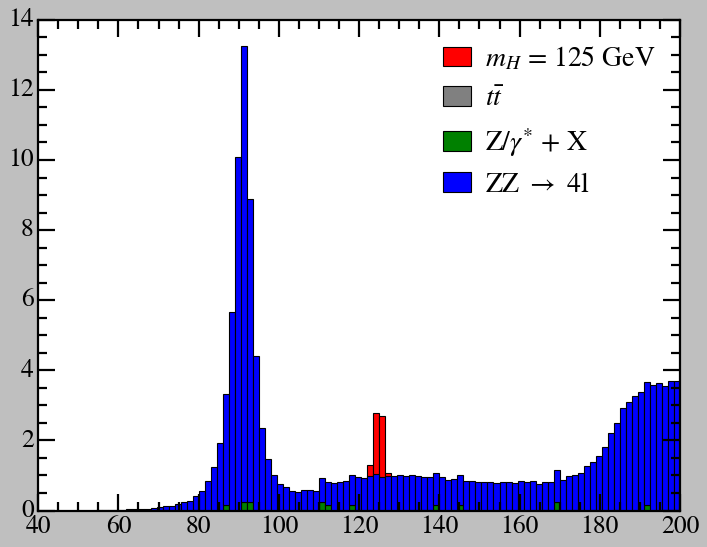

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [ ]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self,
                 all_data,data_labels,
                 fields,field_indices):
        self.all_data = all_data
        self.event_nums = [len(data) for data in all_data]
        self.all_labels = [np.array([label]*len(data)) for label,data in zip(data_labels,all_data)]

        self.fields = fields
        self.field_indices = [field_indices[field] for field in fields]

    def _subsample(self, data, label, n):
        idx = np.random.choice(len(data), n, replace=False)
        return data[idx], label[idx]
    
    def get_pca(self):
        X = []
        Y = []

        for data,label in zip(self.all_data,self.all_labels):
            reduced_data, reduced_label = self._subsample(data,label,min(self.event_nums))
            X.append(reduced_data)
            Y.append(reduced_label)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        return X_pca.numpy()[Y==1], X_pca.numpy()[Y==0]

In [ ]:
mc_all_data = mc_higgs_all_data + mc_zz_all_data
fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(all_data=mc_all_data,
                            data_labels=[1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
                            fields=fields,
                            field_indices=params.field_indices)
higgs_pca, zz_pca = mc_all_pca.get_pca()

In [ ]:
if False:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,0.5)

        plt.tight_layout()
        plt.show()

In [ ]:
mc_higgs_and_zz = utils.FourLeptonsData(
    data_files=[
        MC_dir + 'higgs2011.csv',
        MC_dir + 'higgs2012.csv',

        MC_dir + 'zzto4mu2011.csv',
        MC_dir + 'zzto2mu2e2011.csv',
        MC_dir + 'zzto4e2011.csv',
        MC_dir + 'zzto4mu2012.csv',
        MC_dir + 'zzto2mu2e2012.csv',
        MC_dir + 'zzto4e2012.csv',
    ]
)
all_higgs_and_zz_data = mc_higgs_and_zz.apply_basic_cuts(mc_higgs_and_zz.all_data,show_cut_info=False)
X_higgs_and_zz, Y_higgs_and_zz = mc_higgs_and_zz.get_training_data(
    all_data = all_higgs_and_zz_data,
    data_labels = [1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
    fields = [
        'E1','px1','py1','pz1','eta1','cos_phi1','sin_phi1',
        'E2','px2','py2','pz2','eta2','cos_phi2','sin_phi2',
        'E3','px3','py3','pz3','eta3','cos_phi3','sin_phi3',
        'E4','px4','py4','pz4','eta4','cos_phi4','sin_phi4',
    ],
)
higgs_and_zz_train_loader, higgs_and_zz_val_loader, N_data, N_train, N_val = mc_higgs_and_zz.get_dataloaders(
    X_higgs_and_zz, Y_higgs_and_zz,
    train_ratio=0.8,
    batch_size=2048,
    num_workers=8,
    seed=42,
)

In [ ]:
mc_dataset.N_data

151628

In [ ]:
model = mlp.MLP(
    input_dim=16,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [ ]:
trainer = training.SupervisedTraining(
    model=model,
    trainloader=mc_dataset.train_loader,
    valloader=mc_dataset.val_loader,
    num_epochs=150,
    lr=2e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [ ]:
# trainer.train(save_training_stats_every=10, save_model_every=None, outpath='training_result/MLP/')

Training:   1%|          | 1/150 [00:11<28:42, 11.56s/it]

Epoch 1/150 - Train Loss: 0.63746 - Val Loss: 0.60751


Training:   7%|▋         | 10/150 [01:42<23:32, 10.09s/it]

Epoch 10/150 - Train Loss: 0.33202 - Val Loss: 0.31844


Training:  13%|█▎        | 20/150 [03:23<22:23, 10.34s/it]

Epoch 20/150 - Train Loss: 0.24948 - Val Loss: 0.24538


Training:  20%|██        | 30/150 [05:06<20:24, 10.20s/it]

Epoch 30/150 - Train Loss: 0.21140 - Val Loss: 0.20604


Training:  27%|██▋       | 40/150 [06:46<17:54,  9.77s/it]

Epoch 40/150 - Train Loss: 0.18987 - Val Loss: 0.19310


Training:  33%|███▎      | 50/150 [08:26<17:01, 10.22s/it]

Epoch 50/150 - Train Loss: 0.16953 - Val Loss: 0.17230


Training:  40%|████      | 60/150 [10:07<14:59,  9.99s/it]

Epoch 60/150 - Train Loss: 0.15828 - Val Loss: 0.15987


Training:  47%|████▋     | 70/150 [11:47<13:22, 10.03s/it]

Epoch 70/150 - Train Loss: 0.14632 - Val Loss: 0.14975


Training:  53%|█████▎    | 80/150 [13:24<11:24,  9.78s/it]

Epoch 80/150 - Train Loss: 0.13841 - Val Loss: 0.14511


Training:  60%|██████    | 90/150 [15:02<09:45,  9.75s/it]

Epoch 90/150 - Train Loss: 0.13364 - Val Loss: 0.14183


Training:  67%|██████▋   | 100/150 [16:38<07:58,  9.56s/it]

Epoch 100/150 - Train Loss: 0.12863 - Val Loss: 0.13992


Training:  73%|███████▎  | 110/150 [18:15<06:26,  9.66s/it]

Epoch 110/150 - Train Loss: 0.12391 - Val Loss: 0.13778


Training:  80%|████████  | 120/150 [19:52<04:49,  9.64s/it]

Epoch 120/150 - Train Loss: 0.12019 - Val Loss: 0.13410


Training:  87%|████████▋ | 130/150 [21:29<03:13,  9.67s/it]

Epoch 130/150 - Train Loss: 0.11901 - Val Loss: 0.14377


Training:  93%|█████████▎| 140/150 [23:05<01:35,  9.53s/it]

Epoch 140/150 - Train Loss: 0.11867 - Val Loss: 0.13799


Training: 100%|██████████| 150/150 [24:41<00:00,  9.87s/it]

Epoch 150/150 - Train Loss: 0.12320 - Val Loss: 0.18793


In [ ]:
training_stats = pickle.load(open('training_result/MLP/training_stats.pkl', 'rb'))

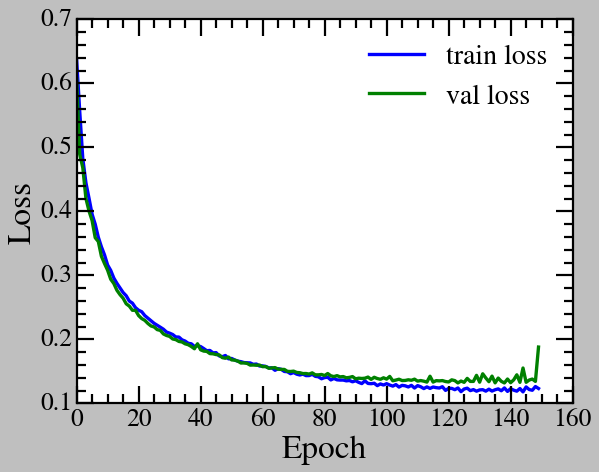

In [ ]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

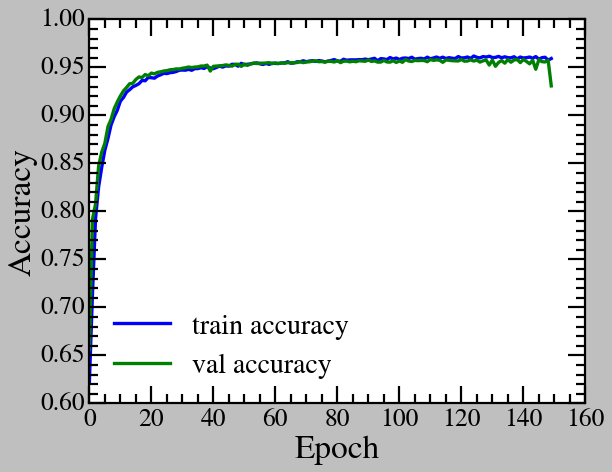

In [ ]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [ ]:
best_model_idx = np.argmin(training_stats['val_losses'])

print('Best detection rate:', training_stats['val_P_detections'][best_model_idx])
print('Best false alarm rate:', training_stats['val_P_false_alarms'][best_model_idx])

Best detection rate: 0.9755494554837545
Best false alarm rate: 0.059255853792031604


In [ ]:
best_model = model.load_state_dict(torch.load('training_result/MLP/model/best.pth',weights_only=False)['model_state_dict'])